<a href="https://colab.research.google.com/github/thejayden/IM4483-Mini-Proj/blob/master/im4483_tanjiadian_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

!pip install pillow

In [2]:
!git clone https://github.com/thejayden/IM4483-Mini-Proj.git

Cloning into 'IM4483-Mini-Proj'...
remote: Enumerating objects: 25552, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 25552 (delta 4), reused 0 (delta 0), pack-reused 25537
Receiving objects: 100% (25552/25552), 1.03 GiB | 28.52 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Checking out files: 100% (25504/25504), done.


In [3]:
train_cat_dir = os.path.join(os.getcwd(), 'IM4483-Mini-Proj', 'train', 'cat')
train_dog_dir = os.path.join(os.getcwd(), 'IM4483-Mini-Proj', 'train', 'dog')
train_cat_images = os.listdir(train_cat_dir)
train_dog_images = os.listdir(train_dog_dir)

category_cat = []
category_dog = []

for image in train_cat_images:
  category_cat.append("0")
df_train = pd.DataFrame({
    'filename': train_cat_images,
    'category': category_cat
})
df_train = df_train.sample(frac=0.5)

for image in train_dog_images:
  category_dog.append("1")
df_train2 = pd.DataFrame({
    'filename': train_dog_images,
    'category': category_dog
})
df_train2 = df_train2.sample(frac=0.5)

df_train = df_train.append(df_train2)
df_train.shape

(10000, 2)

In [4]:
df_train_sample = df_train.sample(n=20)
print(df_train_sample)

           filename category
7900   cat.6772.jpg        0
9020   cat.5451.jpg        0
2369   dog.1033.jpg        1
5220   cat.8215.jpg        0
8311   dog.1069.jpg        1
6521   dog.7688.jpg        1
7114   dog.6227.jpg        1
1161   dog.3585.jpg        1
4290   cat.9115.jpg        0
5       dog.934.jpg        1
9951  dog.11542.jpg        1
4816    dog.460.jpg        1
6096    cat.163.jpg        0
9553  cat.10823.jpg        0
618    dog.3953.jpg        1
77     dog.6363.jpg        1
7757   dog.9067.jpg        1
7894  dog.10620.jpg        1
1921    cat.188.jpg        0
3859    cat.841.jpg        0


In [5]:
val_cat_dir = os.path.join(os.getcwd(), 'IM4483-Mini-Proj', 'val', 'cat')
val_dog_dir = os.path.join(os.getcwd(), 'IM4483-Mini-Proj', 'val', 'dog')
val_cat_images = os.listdir(val_cat_dir)
val_dog_images = os.listdir(val_dog_dir)

category_cat = []
category_dog = []

for image in val_cat_images:
  category_cat.append("0")
df_val = pd.DataFrame({
    'filename': val_cat_images,
    'category': category_cat
})
df_val = df_val.sample(frac=0.5)

for image in val_dog_images:
  category_dog.append("1")
df_val2 = pd.DataFrame({
    'filename': val_dog_images,
    'category': category_dog
})
df_val2 = df_val2.sample(frac=0.5)

df_val = df_val.append(df_val2)
df_val.shape

(2500, 2)

In [6]:
df_val_sample = df_val.sample(n=20)
print(df_val_sample)

           filename category
2036  dog.12224.jpg        1
2364  cat.10405.jpg        0
1055   cat.9150.jpg        0
1881   dog.7727.jpg        1
609    cat.6294.jpg        0
684    dog.4028.jpg        1
1358  cat.10129.jpg        0
1993  cat.11944.jpg        0
1149   cat.6778.jpg        0
2307   cat.3066.jpg        0
1640   dog.2845.jpg        1
1663   dog.2799.jpg        1
30     cat.9612.jpg        0
1495   cat.2498.jpg        0
1522   cat.4489.jpg        0
427    dog.9357.jpg        1
838    dog.6036.jpg        1
686    cat.5494.jpg        0
694   dog.11788.jpg        1
499    cat.2670.jpg        0


Text(0.5, 0, 'Dog = 1, Cat = 0')

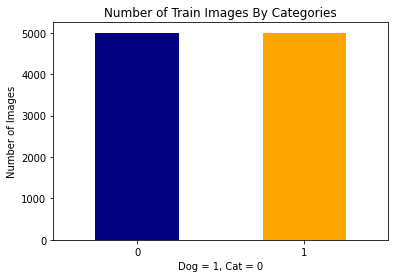

In [7]:
plt1 = df_train['category'].value_counts().plot(kind='bar', color=['navy','orange'], title='Number of Train Images By Categories', rot=0)
plt1.set_ylabel("Number of Images")
plt1.set_xlabel("Dog = 1, Cat = 0")

Text(0.5, 0, 'Dog = 1, Cat = 0')

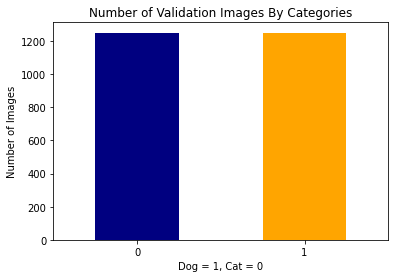

In [8]:
plt2 = df_val['category'].value_counts().plot(kind='bar', color=['navy','orange'], title='Number of Validation Images By Categories', rot=0)
plt2.set_ylabel("Number of Images")
plt2.set_xlabel("Dog = 1, Cat = 0")

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 10
batch_size = 100

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
# for layer in pre_trained_model.layers[:15]:
#     layer.trainable = False

# for layer in pre_trained_model.layers[15:]:
#     layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.1),
              metrics=['accuracy'])

model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [10]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 global_max_pooling2d True
20 dense True
21 dropout True
22 dense_1 True


In [11]:
train_dest = os.path.join(os.getcwd(), 'IM4483-Mini-Proj', 'train')
for img in train_cat_images:
  os.rename(train_cat_dir + "/" + img, train_dest + "/" + img)

In [12]:
for img in train_dog_images:
  os.rename(train_dog_dir + "/" + img, train_dest + "/" + img)

In [13]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    df_train, 
    "./IM4483-Mini-Proj/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

# train_generator = train_datagen.flow_from_dataframe(
#     df_train, 
#     "./IM4483-Mini-Proj/train/dog/", 
#     x_col='filename',
#     y_col='category',
#     class_mode='binary',
#     target_size=(image_size, image_size),
#     batch_size=batch_size
# )

Found 10000 validated image filenames belonging to 2 classes.


          filename category
5315  cat.8836.jpg        0


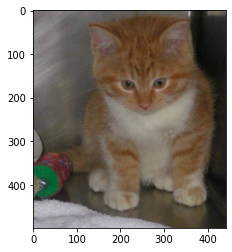

In [14]:
df_train_example = df_train.sample(n=1)
print(df_train_example)

sample = str(df_train_example.iloc[0]['filename'])

# print(sample)
# print("./IM4483-Mini-Proj/train/"+sample)

image = load_img("./IM4483-Mini-Proj/train/"+sample)
plt.imshow(image)

Found 1 validated image filenames belonging to 1 classes.


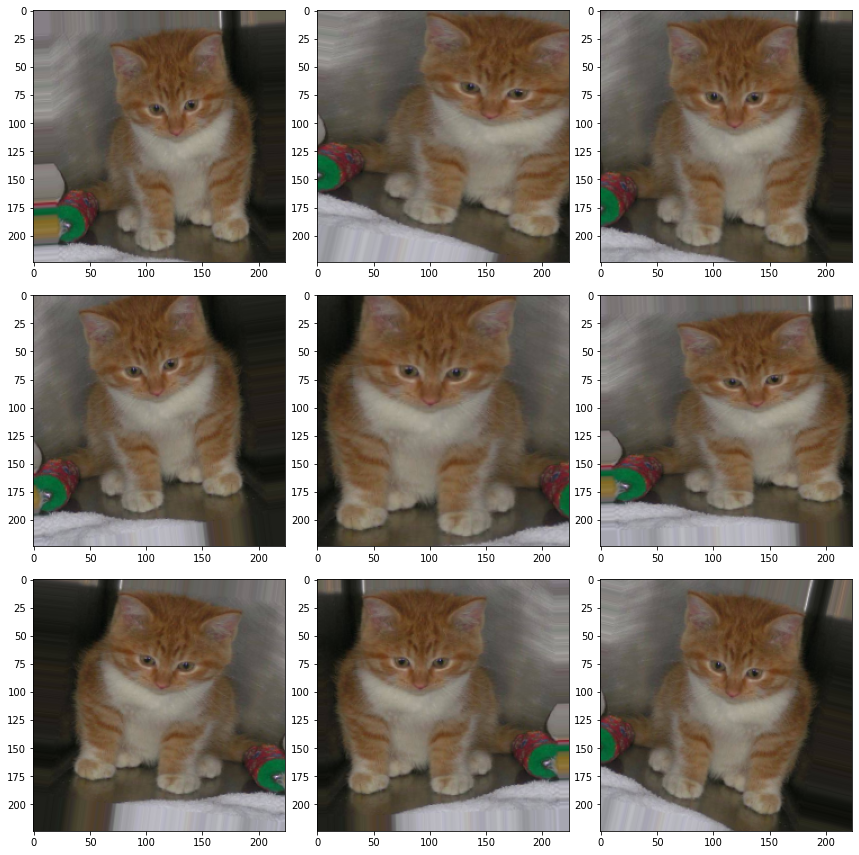

In [15]:
example_generator = train_datagen.flow_from_dataframe(
    df_train_example, 
    "./IM4483-Mini-Proj/train/", 
    x_col='filename',
    y_col='category',
    target_size=(image_size, image_size),
)

plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [16]:
val_dest = os.path.join(os.getcwd(), 'IM4483-Mini-Proj', 'val')
for img in val_cat_images:
  os.rename(val_cat_dir + "/" + img, val_dest + "/" + img)

In [17]:
for img in val_dog_images:
  os.rename(val_dog_dir + "/" + img, val_dest + "/" + img)

In [18]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    df_val, 
    "./IM4483-Mini-Proj/val/",
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2500 validated image filenames belonging to 2 classes.


In [19]:
total_train = df_train.shape[0]
total_validate = df_val.shape[0]

# fine-tune the model
# double forward slash is integer divison operation 
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
100/100 [==============================] - 339s 3s/step - loss: 0.6532 - accuracy: 0.6322 - val_loss: 0.3551 - val_accuracy: 0.8800
Epoch 2/10
100/100 [==============================] - 274s 3s/step - loss: 0.3345 - accuracy: 0.8539 - val_loss: 0.1827 - val_accuracy: 0.9244
Epoch 3/10
100/100 [==============================] - 274s 3s/step - loss: 0.2187 - accuracy: 0.9090 - val_loss: 0.1184 - val_accuracy: 0.9544
Epoch 4/10
100/100 [==============================] - 274s 3s/step - loss: 0.1699 - accuracy: 0.9298 - val_loss: 0.1036 - val_accuracy: 0.9588
Epoch 5/10
100/100 [==============================] - 274s 3s/step - loss: 0.1420 - accuracy: 0.9415 - val_loss: 0.0909 - val_accuracy: 0.9696
Epoch 6/10
100/100 [==============================] - 274s 3s/step - loss: 0.1252 - accuracy: 0.9488 - val_loss: 0.1003 - val_accuracy: 0.9596
Epoch 7/10
100/100 [==============================] - 274s 3s/step - loss: 0.1120 - accuracy: 0.9553 - val_loss: 0.0772 - val_accuracy: 0.9728

In [20]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test: accuracy = 0.975200  ;  loss = 0.065723 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


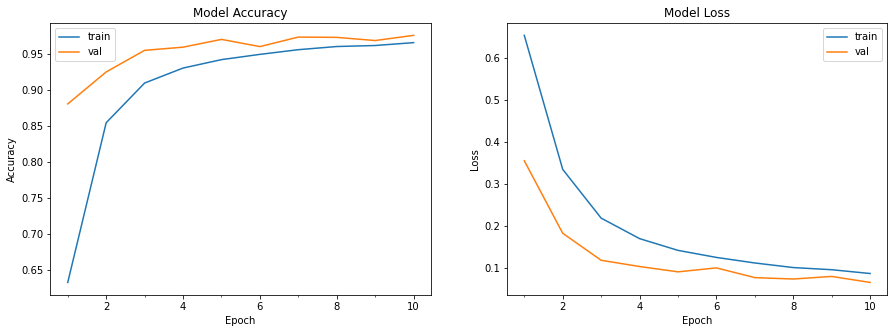

In [21]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [22]:
# # Y_val = df_val['category']
# Y_val_convert = df_val['category'].astype('category')
# y_pred_convert =  model.predict_generator(validation_generator)

In [23]:
# Y_val_convert

In [24]:
# y_pred_convert

In [25]:
# Y_val = df_val['category'].to_numpy()
# Y_val = df_val.to_numpy()
y_pred =  model.predict_generator(validation_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [26]:
Y_val = df_val['category'].astype('int').to_numpy()
Y_val

array([0, 0, 0, ..., 1, 1, 1])

In [27]:
print(type(Y_val))
print(Y_val.size)

<class 'numpy.ndarray'>
2500


In [28]:
y_pred

array([[3.4709426e-03],
       [2.1531365e-05],
       [1.2438940e-02],
       ...,
       [1.1182560e-03],
       [1.4841845e-03],
       [9.9999917e-01]], dtype=float32)

In [29]:
threshold = 0.5
y_final = np.where(y_pred > threshold, 1,0)

In [30]:
y_pred_2 = []
# y_final.size
for x in y_final:
  y_pred_2.append(x[0])
y_pred_2 = np.array(y_pred_2)
y_pred_2

array([0, 0, 0, ..., 0, 0, 1])

In [31]:
print(type(y_pred_2))
print(y_pred_2.size)

<class 'numpy.ndarray'>
2500


In [32]:
# y_final.dtype

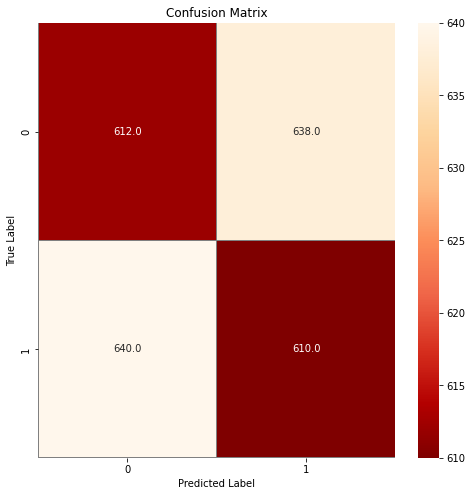

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val, y_pred_2) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="OrRd_r",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [34]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Y_val, y_pred_2, target_names=['0','1'])

print(report)

              precision    recall  f1-score   support

           0       0.49      0.49      0.49      1250
           1       0.49      0.49      0.49      1250

    accuracy                           0.49      2500
   macro avg       0.49      0.49      0.49      2500
weighted avg       0.49      0.49      0.49      2500



In [35]:
test_dir = os.path.join(os.getcwd(), 'IM4483-Mini-Proj', 'test')
test_images = os.listdir(test_dir)

df_test = pd.DataFrame({
  'filename': test_images
})

# df_test.shape
print(df_test)

    filename
0    452.jpg
1    250.jpg
2    466.jpg
3    186.jpg
4    462.jpg
..       ...
495  217.jpg
496  495.jpg
497  400.jpg
498  440.jpg
499   43.jpg

[500 rows x 1 columns]


In [36]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    df_test, 
    "./IM4483-Mini-Proj/test/",
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 500 validated image filenames.


In [37]:
predict = model.predict_generator(test_generator, steps=np.ceil(df_test.shape[0]/batch_size))
threshold = 0.5
df_test['category'] = np.where(predict > threshold, 1,0)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


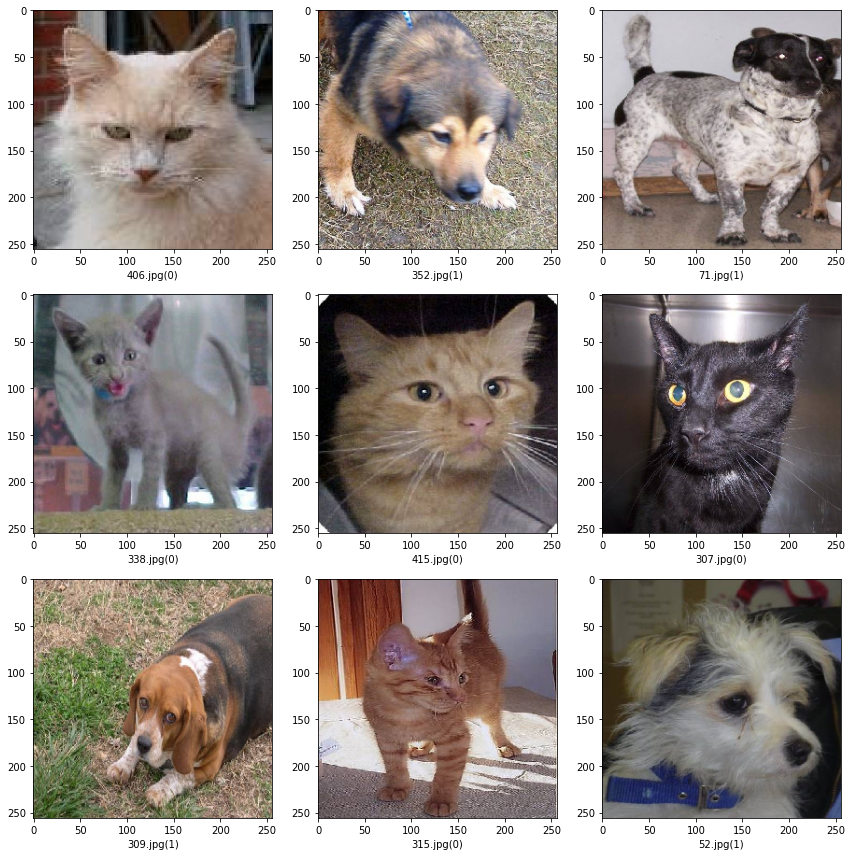

In [38]:
sample_test = df_test.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./IM4483-Mini-Proj/test/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, '(Test data)')

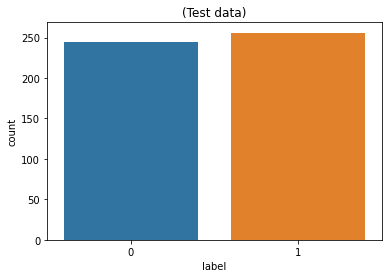

In [39]:
submission_df = df_test.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)

directory = os.path.join(os.getcwd(), 'IM4483-Mini-Proj', 'submission_jiadian.csv')

# if not os.path.exists(directory):
#   os.makedirs(directory)

submission_df.to_csv('submission_jiadian.csv', index=False)
sns.countplot(submission_df['label'])
plt.title("(Test data)")

In [40]:
from google.colab import files
files.download("/content/submission_jiadian.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>